In [248]:
import warnings
warnings.filterwarnings('ignore')

In [249]:
import numpy as np
import pandas as pd
import datetime as dt
import config as cfg

from sqlalchemy import create_engine
import psycopg2

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

import seaborn as sns

## Data Loading / Preprocessing

In [250]:
# import data from AWS RDS Database
conn_string = "host="+cfg.PGHOST +" port="+ "5432" +" dbname="+ cfg.PGDATABASE +" user=" + cfg.PGUSER \
                  +" password="+ cfg.PGPASSWORD
    
conn = psycopg2.connect(conn_string)
cur = conn.cursor()

df = pd.read_sql_query('select * from weather_aus_raw where year >=2011 and year <= 2016',  conn)
df.head()

## Replace 9999 with NaN
df = df.replace('9999', np.nan)
df = df.replace(9999, np.nan)
df.dtypes

date              object
location          object
mintemp          float64
maxtemp          float64
rainfall         float64
evaporation      float64
sunshine         float64
windgustdir       object
windgustspeed    float64
winddir9am        object
winddir3pm        object
windspeed9am     float64
windspeed3pm     float64
humidity9am      float64
humidity3pm      float64
pressure9am      float64
pressure3pm      float64
cloud9am         float64
cloud3pm         float64
temp9am          float64
temp3pm          float64
raintoday         object
raintomorrow      object
year               int64
month              int64
day                int64
dtype: object

In [251]:
# Check Datatypes

df.dtypes

date              object
location          object
mintemp          float64
maxtemp          float64
rainfall         float64
evaporation      float64
sunshine         float64
windgustdir       object
windgustspeed    float64
winddir9am        object
winddir3pm        object
windspeed9am     float64
windspeed3pm     float64
humidity9am      float64
humidity3pm      float64
pressure9am      float64
pressure3pm      float64
cloud9am         float64
cloud3pm         float64
temp9am          float64
temp3pm          float64
raintoday         object
raintomorrow      object
year               int64
month              int64
day                int64
dtype: object

In [252]:
df.isna().count()

date             100935
location         100935
mintemp          100935
maxtemp          100935
rainfall         100935
evaporation      100935
sunshine         100935
windgustdir      100935
windgustspeed    100935
winddir9am       100935
winddir3pm       100935
windspeed9am     100935
windspeed3pm     100935
humidity9am      100935
humidity3pm      100935
pressure9am      100935
pressure3pm      100935
cloud9am         100935
cloud3pm         100935
temp9am          100935
temp3pm          100935
raintoday        100935
raintomorrow     100935
year             100935
month            100935
day              100935
dtype: int64

In [253]:
df['location'].nunique()

49

In [254]:
print(df.shape)
df.head()

(100935, 26)


,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,...,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,year,month,day
0,2011-01-01,Albury,23.2,35.8,0.0,NaN,NaN,ENE,26.0,S,...,1009.2,NaN,NaN,26.8,32.8,No,No,2011,1,1
1,2011-01-02,Albury,20.1,31.1,0.6,NaN,NaN,W,35.0,SW,...,1009.5,NaN,NaN,25.1,30.2,No,No,2011,1,2
2,2011-01-03,Albury,13.6,29.4,0.0,NaN,NaN,WNW,35.0,SSE,...,1009.3,NaN,NaN,20.2,28.4,No,No,2011,1,3
3,2011-01-04,Albury,13.9,29.2,0.0,NaN,NaN,SSE,24.0,SE,...,1007.8,NaN,NaN,19.9,27.9,No,No,2011,1,4
4,2011-01-05,Albury,16.0,28.9,0.0,NaN,NaN,SSE,31.0,ENE,...,1004.3,NaN,NaN,22.0,26.8,No,No,2011,1,5


In [255]:
#import hvplot.pandas
#df.hvplot.hist("rainfall")

<AxesSubplot:>

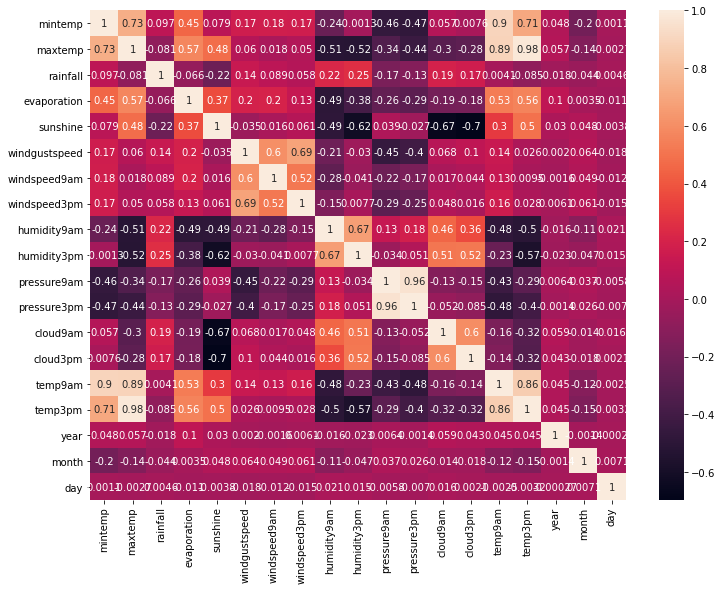

In [256]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))
sns.heatmap(df.corr(), annot=True)

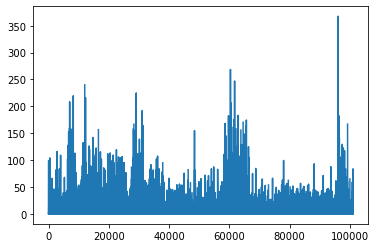

In [257]:
df.rainfall.plot();

In [258]:
df.dtypes

date              object
location          object
mintemp          float64
maxtemp          float64
rainfall         float64
evaporation      float64
sunshine         float64
windgustdir       object
windgustspeed    float64
winddir9am        object
winddir3pm        object
windspeed9am     float64
windspeed3pm     float64
humidity9am      float64
humidity3pm      float64
pressure9am      float64
pressure3pm      float64
cloud9am         float64
cloud3pm         float64
temp9am          float64
temp3pm          float64
raintoday         object
raintomorrow      object
year               int64
month              int64
day                int64
dtype: object

## Feature Selection: Drop Unnecessary Columns / Handle Missing Data

In [259]:
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

columns = ['date', 'location','windgustdir', 'winddir3pm', 'winddir9am', 'raintoday', 'raintomorrow'
            ,'windspeed9am', 'windspeed3pm', 'year', 'month', 'day']
df = df.drop(columns, axis=1)

#num_cols = df.select_dtypes('float64').columns.to_list()
#print('float columns: ', num_cols)

#for col in num_cols:
#    df[col].fillna(df[col].mean(),inplace=True)    

df

,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustspeed,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm
6309,17.8,27.1,0.0,6.0,13.0,52.0,58.0,66.0,1015.9,1013.3,2.0,1.0,25.0,26.6
6310,23.5,30.9,0.0,7.2,11.6,57.0,69.0,72.0,1012.4,1009.6,2.0,3.0,27.0,27.4
6311,22.2,27.6,0.0,3.0,6.3,46.0,82.0,77.0,1011.4,1009.2,7.0,6.0,25.4,26.9
6312,22.7,27.3,0.0,6.6,6.7,50.0,63.0,64.0,1009.2,1008.3,6.0,7.0,25.2,26.4
6313,19.2,25.8,0.0,5.0,1.3,48.0,65.0,71.0,1007.6,1004.5,7.0,7.0,23.9,25.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98124,25.6,33.2,0.6,3.0,8.1,39.0,81.0,66.0,1008.5,1004.7,6.0,5.0,29.4,32.5
98125,25.4,33.4,0.0,4.8,6.3,52.0,85.0,55.0,1006.6,1004.5,8.0,7.0,28.0,32.3
98128,25.2,31.7,25.2,2.2,3.8,41.0,93.0,66.0,1006.8,1003.5,8.0,7.0,26.9,30.6
98129,26.3,30.9,5.4,4.2,0.0,52.0,79.0,90.0,1003.9,1004.1,8.0,8.0,29.6,24.1


In [260]:
df = df.reset_index(drop=True)
print(df.shape)
df.head()

(36929, 14)


,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustspeed,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm
0,17.8,27.1,0.0,6.0,13.0,52.0,58.0,66.0,1015.9,1013.3,2.0,1.0,25.0,26.6
1,23.5,30.9,0.0,7.2,11.6,57.0,69.0,72.0,1012.4,1009.6,2.0,3.0,27.0,27.4
2,22.2,27.6,0.0,3.0,6.3,46.0,82.0,77.0,1011.4,1009.2,7.0,6.0,25.4,26.9
3,22.7,27.3,0.0,6.6,6.7,50.0,63.0,64.0,1009.2,1008.3,6.0,7.0,25.2,26.4
4,19.2,25.8,0.0,5.0,1.3,48.0,65.0,71.0,1007.6,1004.5,7.0,7.0,23.9,25.1


In [261]:
print(df.shape)
#print(num_cols)
df.head()

(36929, 14)


,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustspeed,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm
0,17.8,27.1,0.0,6.0,13.0,52.0,58.0,66.0,1015.9,1013.3,2.0,1.0,25.0,26.6
1,23.5,30.9,0.0,7.2,11.6,57.0,69.0,72.0,1012.4,1009.6,2.0,3.0,27.0,27.4
2,22.2,27.6,0.0,3.0,6.3,46.0,82.0,77.0,1011.4,1009.2,7.0,6.0,25.4,26.9
3,22.7,27.3,0.0,6.6,6.7,50.0,63.0,64.0,1009.2,1008.3,6.0,7.0,25.2,26.4
4,19.2,25.8,0.0,5.0,1.3,48.0,65.0,71.0,1007.6,1004.5,7.0,7.0,23.9,25.1


In [262]:
df.dtypes

mintemp          float64
maxtemp          float64
rainfall         float64
evaporation      float64
sunshine         float64
windgustspeed    float64
humidity9am      float64
humidity3pm      float64
pressure9am      float64
pressure3pm      float64
cloud9am         float64
cloud3pm         float64
temp9am          float64
temp3pm          float64
dtype: object

## Encode Columns - Use OneHotEncoder

In [263]:
# Generate our categorical variable list
#df_cat = df.dtypes[df.dtypes == "object"].index.tolist()
#df_cat

#print(df[df_cat].nunique())
#print(df.shape)
#df.head()

# Create the OneHotEncoder instance
#from sklearn.preprocessing import OneHotEncoder
#enc = OneHotEncoder(sparse=False)

# Fit the encoder and produce encoded DataFrame
#encode_df = pd.DataFrame(enc.fit_transform(df[df_cat]))

# Rename encoded columns
#encode_df.columns = enc.get_feature_names(df_cat)
#encode_df.head()
#print(encode_df.shape)

#print(encode_df.shape)
#encode_df.head()

In [264]:
print(df.shape)
df.head()

(36929, 14)


,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustspeed,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm
0,17.8,27.1,0.0,6.0,13.0,52.0,58.0,66.0,1015.9,1013.3,2.0,1.0,25.0,26.6
1,23.5,30.9,0.0,7.2,11.6,57.0,69.0,72.0,1012.4,1009.6,2.0,3.0,27.0,27.4
2,22.2,27.6,0.0,3.0,6.3,46.0,82.0,77.0,1011.4,1009.2,7.0,6.0,25.4,26.9
3,22.7,27.3,0.0,6.6,6.7,50.0,63.0,64.0,1009.2,1008.3,6.0,7.0,25.2,26.4
4,19.2,25.8,0.0,5.0,1.3,48.0,65.0,71.0,1007.6,1004.5,7.0,7.0,23.9,25.1


In [265]:
# Merge one-hot encoded features and drop the originals
#df = df.merge(encode_df,left_index=True, right_index=True)
#df = df.drop(df_cat, axis=1)
#df.head()

In [266]:
df.columns

Index(['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine',
       'windgustspeed', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'temp9am', 'temp3pm'],
      dtype='object')

In [267]:
print(df.shape)
df.head()

(36929, 14)


,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustspeed,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm
0,17.8,27.1,0.0,6.0,13.0,52.0,58.0,66.0,1015.9,1013.3,2.0,1.0,25.0,26.6
1,23.5,30.9,0.0,7.2,11.6,57.0,69.0,72.0,1012.4,1009.6,2.0,3.0,27.0,27.4
2,22.2,27.6,0.0,3.0,6.3,46.0,82.0,77.0,1011.4,1009.2,7.0,6.0,25.4,26.9
3,22.7,27.3,0.0,6.6,6.7,50.0,63.0,64.0,1009.2,1008.3,6.0,7.0,25.2,26.4
4,19.2,25.8,0.0,5.0,1.3,48.0,65.0,71.0,1007.6,1004.5,7.0,7.0,23.9,25.1


In [268]:
df.columns

Index(['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine',
       'windgustspeed', 'humidity9am', 'humidity3pm', 'pressure9am',
       'pressure3pm', 'cloud9am', 'cloud3pm', 'temp9am', 'temp3pm'],
      dtype='object')

## Variable Declaration and Split into Test/Train

In [269]:
# define Target Variable
X = df.copy()
X = X.drop("rainfall", axis=1)
y = df["rainfall"]

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,train_size = 0.70)

In [270]:
print(len(X_train))
print(len(X_test))

25850
11079


## Scale the Data
- StandardScaler
- MinMaxScaler

#### Using StandardScaler for the mock up

In [271]:
from sklearn.preprocessing import StandardScaler

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Linear Regression

In [272]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_pred_lr



array([5.81374392, 2.77828581, 1.56037839, ..., 1.10968871, 7.03462443,
       3.74582539])

In [273]:
print("Training accuracy: ", lr.score(X_train_scaled, y_train))
print("Testing accuracy: ", lr.score(X_test_scaled, y_test))

Training accuracy:  0.13523364434222085
Testing accuracy:  0.16280327294834507


In [274]:
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_lr})
df_res = df_res.reset_index(drop=True)
df_res

,Actual,Predicted
0,1.4,5.813744
1,0.0,2.778286
2,1.2,1.560378
3,0.0,-0.417802
4,0.0,3.743298
...,...,...
11074,0.0,6.853118
11075,0.0,5.372659
11076,0.2,1.109689
11077,4.0,7.034624


## Random Forest

In [275]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor( n_estimators=500, random_state=0)
#rf_reg = RandomForestRegressor(random_state=0)
rf_reg.fit(X_train_scaled, y_train)
print("Training accuracy: ", rf_reg.score(X_train_scaled, y_train))
print("Testing accuracy: ", rf_reg.score(X_test_scaled, y_test))

Training accuracy:  0.9037459735248407
Testing accuracy:  0.3196778607913461


In [276]:
y_pred_rf = rf_reg.predict(X_test_scaled)
y_pred_rf

df_res_rf = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf})
df_res_rf = df_res.reset_index(drop=True)
df_res_rf

,Actual,Predicted
0,1.4,5.813744
1,0.0,2.778286
2,1.2,1.560378
3,0.0,-0.417802
4,0.0,3.743298
...,...,...
11074,0.0,6.853118
11075,0.0,5.372659
11076,0.2,1.109689
11077,4.0,7.034624


## Model Comparison

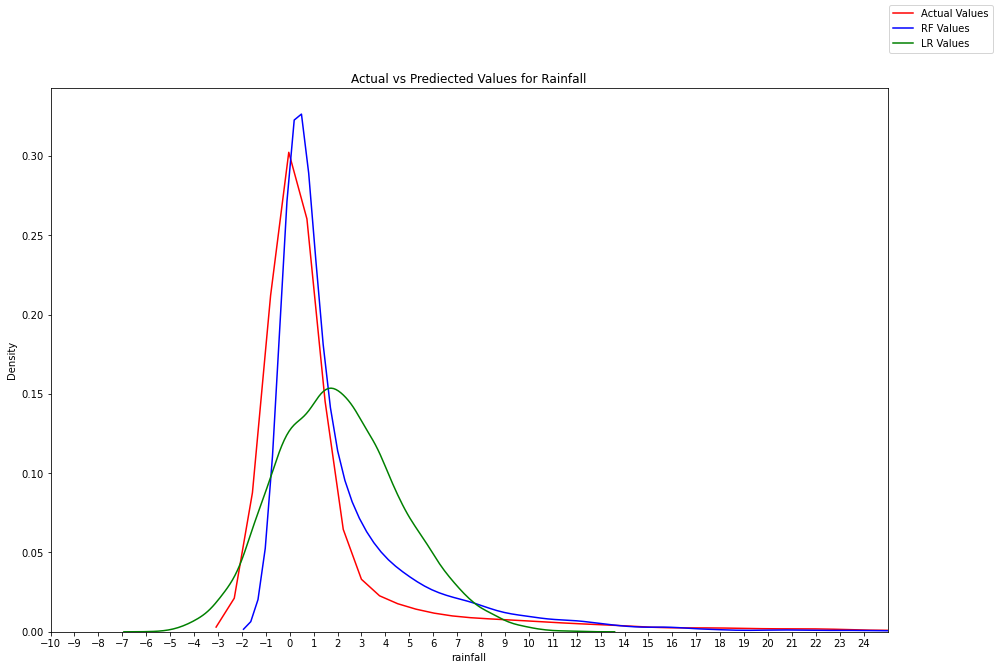

In [277]:
import seaborn as sns
fig = plt.figure(figsize=(15, 10))


ax = sns.distplot(y_test, hist=False, color="r", label="Actual Values")
sns.distplot(y_pred_rf, hist=False, color="b", label="RF Values" , ax=ax)
sns.distplot(y_pred_lr, hist=False, color="g", label="LR Values" , ax=ax)
ax.set_xlim(-10, 25)
ax.set_xticks(range(-10,25))
fig.legend(labels=['Actual Values','RF Values', 'LR Values'])


plt.title('Actual vs Prediected Values for Rainfall')


plt.show()
plt.close()

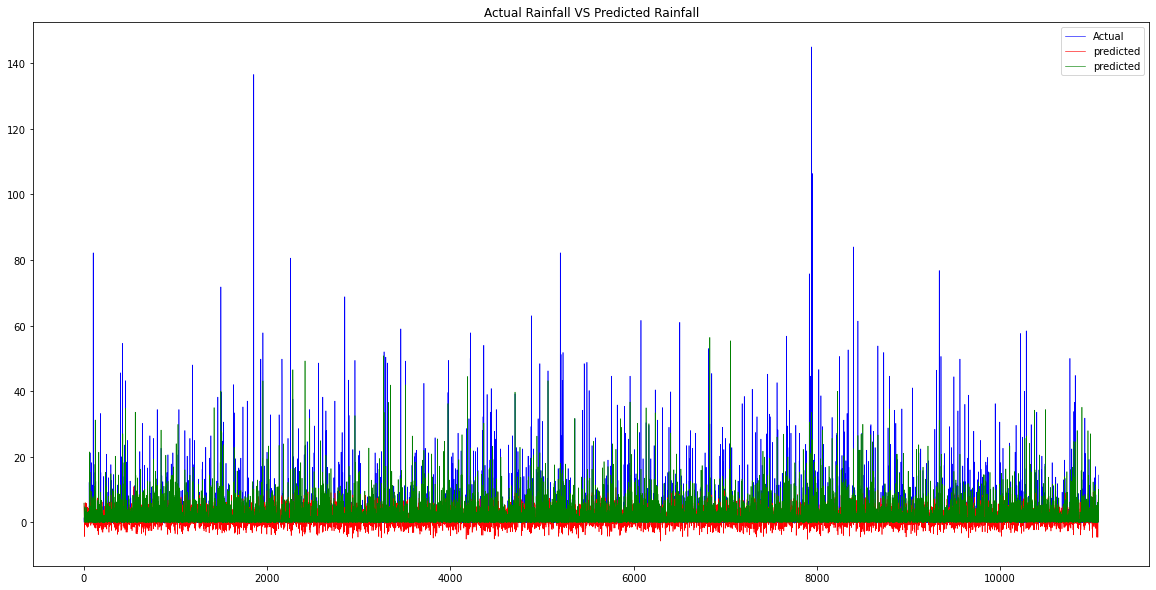

In [278]:
x_value=range(len(y_test))
plt.figure(figsize=(20,10))
plt.plot(x_value,y_test,color='blue',label='Actual',lw=.6)
plt.plot(x_value,y_pred_lr,color='red',label='predicted',lw=.6)
plt.plot(x_value,y_pred_rf,color='green',label='predicted',lw=.6)
plt.legend()
plt.title('Actual Rainfall VS Predicted Rainfall')
plt.show()

## 2017 Predictions

In [279]:
df_2017 = pd.read_sql_query('select * from weather_aus_raw where year = 2017 and month = 1',  conn)
df_2017.head()

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,...,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,year,month,day
0,2017-01-01,Albury,15.5,31.6,0.0,9999.0,9999.0,WSW,39.0,E,...,1004.1,9999.0,9999.0,23.4,31.4,No,No,2017,1,1
1,2017-01-02,Albury,14.9,32.0,0.0,9999.0,9999.0,SE,35.0,SSW,...,1009.9,9999.0,9999.0,20.6,30.5,No,No,2017,1,2
2,2017-01-03,Albury,13.7,32.0,0.0,9999.0,9999.0,SE,24.0,SSE,...,1014.7,9999.0,9999.0,21.1,29.5,No,No,2017,1,3
3,2017-01-04,Albury,16.2,33.0,0.0,9999.0,9999.0,NNW,26.0,SE,...,1015.4,9999.0,9999.0,23.9,31.2,No,No,2017,1,4
4,2017-01-05,Albury,18.0,33.5,0.0,9999.0,9999.0,SSE,35.0,ENE,...,1013.1,9999.0,9999.0,24.3,32.4,No,No,2017,1,5


In [280]:
df_2017 = df_2017.replace('9999', np.nan)
df_2017 = df_2017.replace(9999, np.nan)

num_cols = df_2017.select_dtypes('float64').columns.to_list()
#print('\n float columns: ', num_cols)

for col in num_cols:
    df_2017[col].fillna(df_2017[col].mean(),inplace=True)
    
# Hanlde Nan in object columns
obj_cols = df_2017.select_dtypes('object').columns.to_list()
#print('\n object columns: ', obj_cols)

for col in obj_cols:
    df_2017[col].fillna(df_2017[col].mode(),inplace=True) 

columns = ['date', 'location','windgustdir', 'winddir3pm', 'winddir9am', 'raintoday', 'raintomorrow'
            ,'windspeed9am', 'windspeed3pm', 'year', 'month', 'day', "rainfall"]

X_2017 = df_2017.drop(columns, axis=1)
y_2017 = df_2017["rainfall"]

print(X_2017.shape)
print(y_2017.shape)

(1519, 13)
(1519,)


In [283]:
X_2017_scaled = X_scaler.transform(X_2017)
y_pred_2017 = rf_reg.predict(X_2017_scaled)
y_pred_2017

array([0.1568, 0.3388, 0.0252, ..., 0.3492, 0.3976, 0.3748])

In [285]:
df_2017_res = pd.DataFrame({'Actual': y_2017, 'Predicted': y_pred_2017})
#df_2017_res = df_2017_res.reset_index(drop=True)
#print(df_2017_res.shape())
df_2017_res.head(5)

,Actual,Predicted
0,0.0,0.1568
1,0.0,0.3388
2,0.0,0.0252
3,0.0,0.0040
4,0.0,0.0192


In [286]:
df_merge_2017 = df_2017_res.merge(df_2017,left_index=True, right_index=True)
df_merge_2017.head(5)

,Actual,Predicted,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,...,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,year,month,day
0,0.0,0.1568,2017-01-01,Albury,15.5,31.6,0.0,8.940755,9.25369,WSW,...,1004.1,5.283293,4.424069,23.4,31.4,No,No,2017,1,1
1,0.0,0.3388,2017-01-02,Albury,14.9,32.0,0.0,8.940755,9.25369,SE,...,1009.9,5.283293,4.424069,20.6,30.5,No,No,2017,1,2
2,0.0,0.0252,2017-01-03,Albury,13.7,32.0,0.0,8.940755,9.25369,SE,...,1014.7,5.283293,4.424069,21.1,29.5,No,No,2017,1,3
3,0.0,0.0040,2017-01-04,Albury,16.2,33.0,0.0,8.940755,9.25369,NNW,...,1015.4,5.283293,4.424069,23.9,31.2,No,No,2017,1,4
4,0.0,0.0192,2017-01-05,Albury,18.0,33.5,0.0,8.940755,9.25369,SSE,...,1013.1,5.283293,4.424069,24.3,32.4,No,No,2017,1,5


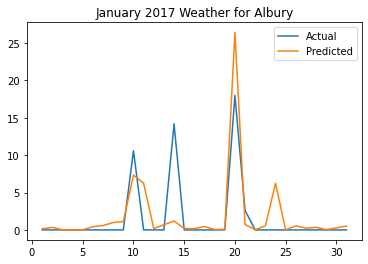

In [287]:
import matplotlib.pyplot as plt
# Create the plot
df_merge_2017_albury = df_merge_2017[df_merge_2017['location'] == 'Albury']
x_axis = df_merge_2017_albury['day']
y_axis_actual = df_merge_2017_albury['Actual']
y_axis_pred = df_merge_2017_albury['Predicted']

plt.plot(x_axis, y_axis_actual, label = "Actual")
plt.plot(x_axis, y_axis_pred, label = "Predicted")
plt.title("January 2017 Weather for Albury")

plt.legend()
plt.show()